### Training a CycleGAN 

In [18]:
import torch
import torch.nn as nn
import torchvision
import os
import pickle
import scipy.io
import numpy as np

from torch.backends import cudnn


from torch.autograd import Variable
from torch import optim
from cycle_model import G12, G21
from cycle_model import D1, D2

# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels, checkAndCreateFolder
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import argparse

from numpy import save as np_save
from numpy import load as np_load

import PIL.Image
from cStringIO import StringIO
from os import fsync

import imageio

In [19]:
def sync(fh):
    """
    This makes sure data is written to disk, so that buffering doesn't influence the timings.
    """
    fh.flush()
    fsync(fh.fileno())

In [20]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')
    
    return plt

In [28]:
# load only from a single class for now

classes = [0]
instances = [100 for i in range(10)]
batchSize = 64

mnist_dataset = loadDataset('MNIST', classes, instances, 'train')
mnist_dataloader = torch.utils.data.DataLoader(mnist_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

classes = [0]
instances = [6000 for i in range(10)]


svhn_dataset = loadDataset('SVHN', classes, instances, 'train')
svhn_dataloader = torch.utils.data.DataLoader(svhn_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

In [22]:
numInputChannels = 100
numGenFilter = 64
numDiscFilter = 64
numOutputChannels = 1


learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

numOfSamples = 1000

image_size = 32
g_conv_dim = 64
d_conv_dim = 64
use_reconst_loss = True
use_labels = True
num_classes = 10



train_iters = 10000
batch_size = 64
num_workers =  default=2
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

In [23]:
def str2bool(v):
    return v.lower() in ('true')

parser = argparse.ArgumentParser()

# model hyper-parameters
image_size = 32
g_conv_dim=64
d_conv_dim=64
use_reconst_loss = True
use_labels = True 
num_classes = 10

# training hyper-parameters
train_iters = 40000
batch_size = 64
num_workers = 2
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# misc
mode = 'train'
model_path = './CycleGAN/models'
sample_path = './CycleGAN/samples'

log_step = 1000
sample_step = 1000

In [24]:
def to_var( x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def to_data( x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

In [25]:
class Solver(object):
    
    def __init__(self,  svhn_loader, mnist_loader):
        
        self.svhn_loader = svhn_loader
        self.mnist_loader = mnist_loader
        self.g12 = None
        self.g21 = None
        self.d1 = None
        self.d2 = None
        self.g_optimizer = None
        self.d_optimizer = None
        self.use_reconst_loss = use_reconst_loss
        self.use_labels = use_labels
        self.num_classes = num_classes
        self.beta1 = beta1
        self.beta2 = beta2
        self.g_conv_dim = g_conv_dim
        self.d_conv_dim = d_conv_dim
        self.train_iters = train_iters
        self.batch_size = batch_size
        self.lr = lr
        self.log_step = log_step
        self.sample_step = sample_step
        self.sample_path = sample_path
        self.model_path = model_path
        self.build_model()
        
    def build_model(self):
        """Builds a generator and a discriminator."""
        self.g12 = G12(conv_dim=self.g_conv_dim)
        self.g21 = G21(conv_dim=self.g_conv_dim)
        self.d1 = D1(conv_dim=self.d_conv_dim, use_labels=self.use_labels)
        self.d2 = D2(conv_dim=self.d_conv_dim, use_labels=self.use_labels)
        
        g_params = list(self.g12.parameters()) + list(self.g21.parameters())
        d_params = list(self.d1.parameters()) + list(self.d2.parameters())
        
        self.g_optimizer = optim.Adam(g_params, self.lr, [self.beta1, self.beta2])
        self.d_optimizer = optim.Adam(d_params, self.lr, [self.beta1, self.beta2])
        
        if torch.cuda.is_available():
            self.g12.cuda()
            self.g21.cuda()
            self.d1.cuda()
            self.d2.cuda()
    
    def merge_images(self, sources, targets, k=10):
        _, _, h, w = sources.shape
        row = int(np.sqrt(self.batch_size))
        merged = np.zeros([3, row*h, row*w*2])
        for idx, (s, t) in enumerate(zip(sources, targets)):
            i = idx // row
            j = idx % row
            
            '''
            print s.shape
            print t.shape
            
            print i, j
            print i*h, (i+1)*h
            print (j*2)*h, (j*2+1)*h
            print (j*2+1)*h, (j*2+2)*h
            '''

            merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
            merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
            
        return merged.transpose(1, 2, 0)
    
    
    def reset_grad(self):
        """Zeros the gradient buffers."""
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def train(self):
        
        svhn_iter = iter(self.svhn_loader)
        mnist_iter = iter(self.mnist_loader)
        
        
        iter_per_epoch = min(len(svhn_iter), len(mnist_iter))
        
        # fixed mnist and svhn for sampling
        fixed_svhn = to_var(svhn_iter.next()[0])
        fixed_mnist = to_var(mnist_iter.next()[0])
        
        # loss if use_labels = True
        criterion = nn.CrossEntropyLoss()
        
        for step in range(self.train_iters+1):
            # reset data_iter for each epoch
            if (step+1) % iter_per_epoch == 0:
                mnist_iter = iter(self.mnist_loader)
                svhn_iter = iter(self.svhn_loader)
            
            # load svhn and mnist dataset
            svhn, s_labels = svhn_iter.next() 
            svhn, s_labels = to_var(svhn), to_var(s_labels).long().squeeze()
            mnist, m_labels = mnist_iter.next() 
            mnist, m_labels = to_var(mnist), to_var(m_labels)

            if self.use_labels:
                mnist_fake_labels = to_var(
                    torch.Tensor([self.num_classes]*svhn.size(0)).long())
                svhn_fake_labels = to_var(
                    torch.Tensor([self.num_classes]*mnist.size(0)).long())
            
            #============ train D ============#
            
            # train with real images
            self.reset_grad()
            out = self.d1(mnist)
            if self.use_labels:
                d1_loss = criterion(out, m_labels)
            else:
                d1_loss = torch.mean((out-1)**2)
            
            out = self.d2(svhn)
            if self.use_labels:
                d2_loss = criterion(out, s_labels)
            else:
                d2_loss = torch.mean((out-1)**2)
            
            d_mnist_loss = d1_loss
            d_svhn_loss = d2_loss
            d_real_loss = d1_loss + d2_loss
            d_real_loss.backward()
            self.d_optimizer.step()
            
            # train with fake images
            self.reset_grad()
            fake_svhn = self.g12(mnist)
            out = self.d2(fake_svhn)
            if self.use_labels:
                d2_loss = criterion(out, svhn_fake_labels)
            else:
                d2_loss = torch.mean(out**2)
            
            fake_mnist = self.g21(svhn)
            out = self.d1(fake_mnist)
            if self.use_labels:
                d1_loss = criterion(out, mnist_fake_labels)
            else:
                d1_loss = torch.mean(out**2)
            
            d_fake_loss = d1_loss + d2_loss
            d_fake_loss.backward()
            self.d_optimizer.step()
            
            #============ train G ============#
            
            # train mnist-svhn-mnist cycle
            self.reset_grad()
            fake_svhn = self.g12(mnist)
            out = self.d2(fake_svhn)
            reconst_mnist = self.g21(fake_svhn)
            if self.use_labels:
                g_loss = criterion(out, m_labels) 
            else:
                g_loss = torch.mean((out-1)**2) 

            if self.use_reconst_loss:
                g_loss += torch.mean((mnist - reconst_mnist)**2)

            g_loss.backward()
            self.g_optimizer.step()

            # train svhn-mnist-svhn cycle
            self.reset_grad()
            fake_mnist = self.g21(svhn)
            out = self.d1(fake_mnist)
            reconst_svhn = self.g12(fake_mnist)
            if self.use_labels:
                g_loss = criterion(out, s_labels) 
            else:
                g_loss = torch.mean((out-1)**2) 

            if self.use_reconst_loss:
                g_loss += torch.mean((svhn - reconst_svhn)**2)

            g_loss.backward()
            self.g_optimizer.step()
            
            # print the log info
            if (step+1) % self.log_step == 0:
                print('Step [%d/%d], d_real_loss: %.4f, d_mnist_loss: %.4f, d_svhn_loss: %.4f, '
                      'd_fake_loss: %.4f, g_loss: %.4f' 
                      %(step+1, self.train_iters, d_real_loss.data[0], d_mnist_loss.data[0], 
                        d_svhn_loss.data[0], d_fake_loss.data[0], g_loss.data[0]))

            # save the sampled images
            if (step+1) % self.sample_step == 0:
                
                fake_svhn = self.g12(fixed_mnist)
                fake_mnist = self.g21(fixed_svhn)
                
                mnist, fake_mnist = to_data(fixed_mnist), to_data(fake_mnist)
                svhn , fake_svhn = to_data(fixed_svhn), to_data(fake_svhn)
                                
                merged = self.merge_images(mnist, fake_svhn)
                path = os.path.join(self.sample_path, 'sample-%d-m-s.png' %(step+1))
                scipy.misc.imsave(path, merged)
                print ('saved %s' %path)
                
                merged = self.merge_images(svhn, fake_mnist)
                path = os.path.join(self.sample_path, 'sample-%d-s-m.png' %(step+1))
                scipy.misc.imsave(path, merged)
                print ('saved %s' %path)
            
            if (step+1) % 5000 == 0:
                # save the model parameters for each epoch
                g12_path = os.path.join(self.model_path, 'g12-%d.pkl' %(step+1))
                g21_path = os.path.join(self.model_path, 'g21-%d.pkl' %(step+1))
                d1_path = os.path.join(self.model_path, 'd1-%d.pkl' %(step+1))
                d2_path = os.path.join(self.model_path, 'd2-%d.pkl' %(step+1))
                torch.save(self.g12.state_dict(), g12_path)
                torch.save(self.g21.state_dict(), g21_path)
                torch.save(self.d1.state_dict(), d1_path)
                torch.save(self.d2.state_dict(), d2_path)

In [17]:
solver = Solver(svhn_dataloader, mnist_dataloader)
cudnn.benchmark = True 

# create directories if not exist
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(sample_path):
    os.makedirs(sample_path)

if mode == 'train':
    solver.train()
elif mode == 'sample':
    solver.sample()

Step [1000/40000], d_real_loss: 0.7635, d_mnist_loss: 0.0716, d_svhn_loss: 0.6919, d_fake_loss: 0.7976, g_loss: 4.0369
saved ./CycleGAN/samples/sample-1000-m-s.png
saved ./CycleGAN/samples/sample-1000-s-m.png
Step [2000/40000], d_real_loss: 0.6896, d_mnist_loss: 0.0144, d_svhn_loss: 0.6751, d_fake_loss: 0.6997, g_loss: 5.9417
saved ./CycleGAN/samples/sample-2000-m-s.png
saved ./CycleGAN/samples/sample-2000-s-m.png
Step [3000/40000], d_real_loss: 0.7105, d_mnist_loss: 0.0053, d_svhn_loss: 0.7053, d_fake_loss: 0.6588, g_loss: 7.2103
saved ./CycleGAN/samples/sample-3000-m-s.png
saved ./CycleGAN/samples/sample-3000-s-m.png
Step [4000/40000], d_real_loss: 0.6780, d_mnist_loss: 0.0250, d_svhn_loss: 0.6530, d_fake_loss: 0.7232, g_loss: 5.1749
saved ./CycleGAN/samples/sample-4000-m-s.png
saved ./CycleGAN/samples/sample-4000-s-m.png
Step [5000/40000], d_real_loss: 0.7158, d_mnist_loss: 0.0003, d_svhn_loss: 0.7155, d_fake_loss: 0.6803, g_loss: 9.5290
saved ./CycleGAN/samples/sample-5000-m-s.png


Exception KeyboardInterrupt in <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3993fdccd0>> ignored
Process Process-85349:
Traceback (most recent call last):
Process Process-85351:
Process Process-85352:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-85353:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
    self._target(*self._args, **self._kwargs)
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/pro

KeyboardInterrupt: 

  File "/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt


In [29]:
def test():
    
    '''
    Inputs :

    dataSets : List : Datasets for which samples are to be genrated
    instances : List : Number of instances to be used from original dataset
    classes : List : Classes for which samples are to be generated

    Output :

    File with 1000 compressed images generated by GAN

    '''

    # pretrained cycleGAN model
    modelFolder = 'CycleGAN/models'+'/'
    modelFile = modelFolder+'g21-10000'+'.pkl'    


    # load the model leannt during training, SVHN to MNIST model
    g21 = G21(conv_dim=g_conv_dim)
    g21.load_state_dict(torch.load(modelFile))

    if torch.cuda.is_available():
        g21.cuda()

            
    svhn_iter = iter(svhn_dataloader)



    # fixed mnist and svhn for sampling
    fixed_svhn = to_var(svhn_iter.next()[0])
    print len(svhn_iter)
    for sample in range(len(svhn_iter)-1):
        # load svhn and mnist dataset
        svhn, s_labels = svhn_iter.next() 
        svhn, s_labels = to_var(svhn), to_var(s_labels).long().squeeze()     
        
        fake_mnist = g21(svhn)
        fake_mnist = to_data(fake_mnist)
        genImage = fake_mnist
        
        maxImage = np.max(genImage)
        minImage = np.min(genImage)
        #print maxImage, minImage

        genImage = np.multiply(np.divide((genImage-minImage),(maxImage-minImage)),255.0)
        maxImage = np.max(genImage)
        minImage = np.min(genImage)

        if sample==0:
            genImageConcat = genImage
        elif sample>=1:
            genImageConcat = np.concatenate((genImageConcat, genImage),
                                            axis=0)
    testFolderName = './CycleGAN/test'+'/'
    checkAndCreateFolder(testFolderName)

    testFileName = testFolderName+'Experiment4a.npy'

    # save the image in some format
    with open(testFileName,'wb+') as fh:
        genImageConcat = np.squeeze(genImageConcat)
        np_save(fh, genImageConcat, allow_pickle=False)
        sync(fh)

In [30]:
test()

77


In [31]:
def showImageMatrix():
    '''
    Inputs :
    
    dataSets : List : Datasets for which samples are to be genrated
    instances : List : Number of instances to be used from original dataset
    classes : List : Classes for which samples are to be generated
    
    Outputs :
    
    5x5 image matrix 
    
    '''
    testFolderName = './CycleGAN/test'+'/'
    testFileName = testFolderName+'Experiment4a'+'.npy'
    images = np_load(testFileName)
    
    # get random list of images to be displayed
    randomList = np.random.randint(0,1000,(25))
    imageList = images[randomList]
    
    
    fmt = 'png'
    
    # need to generalise this snippet
    fig, axes = plt.subplots(5,5)
    fig.tight_layout()
    fig.subplots_adjust(wspace=-0.7, hspace=-0.1)
    plt.axis('off')
    
    for i in range(5):
        for j in range(5):
            f = StringIO()
            image = PIL.Image.fromarray(np.uint8(imageList[i*5+j]))
            image.save(f,fmt)
            axes[i,j].imshow(image, cmap='Greys_r')
            axes[i,j].axis('off')
            axes[i,j].set_xticklabels([])
            axes[i,j].set_yticklabels([])
            axes[i,j].set_aspect("equal")
    
    resultFolderName = './CycleGAN/results'+'/'
    checkAndCreateFolder(resultFolderName)
    resultFileName = resultFolderName+'/'+'Experiment4a'+'.png'
    plt.savefig(resultFileName, bbox_inches='tight')
    plt.show()
    plt.close()


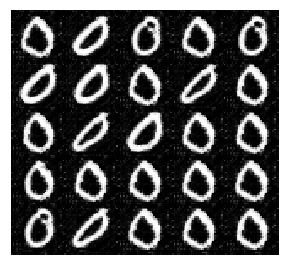

In [32]:
showImageMatrix()